In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils
from wiki.newphet import load_prophet_prop
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output
import gc

In [3]:
def load_plot(page, plot_y_org=True):
    forecast = pd.read_feather(PROPHET_PATH+VERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()
    forecast = pd.read_feather(PROPHET_PATH+YVERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [4]:
PROPHET_PATH = '../data/prophet/'
CACHE_PATH = 'cache/'
RESULTS_PATH = 'results/'
VERSION ='v7t/'
YVERSION ='v7ty/'

In [5]:
mediandf = pd.read_feather('../data/median_for_120_60.f') 

In [6]:
test_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f'); 
test_df.page_index = test_df.page_index.astype(int)
print(test_df[VERSION[:-1]+'_train'].mean())
test_df = test_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#test_df = test_df.drop(VERSION[:-1]+'_train', axis=1)
print(test_df.shape)
print(test_df.info())
print(test_df[VERSION[:-1]+'_val'].mean())
test_df.head()

66.9608163262
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7t_train     145063 non-null float64
v7t_val       144151 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
99.0350088156


,page_index,v7t_train,v7t_val
0,0,46.736751,32.642601
1,1,48.666767,83.565553
2,2,69.758611,120.451293
3,3,45.255355,38.493515
4,4,66.002965,89.498846


In [7]:
mediandf.page_index = mediandf.page_index.astype(int)
mediandf = mediandf.sort_values(by='page_index').reset_index().drop('index', axis=1)
print(mediandf.iloc[:,2:].mean())
print(mediandf.info())
mediandf.head()

median_pred_60               945.877619
median_pred_120             1079.880355
prevYear_median_pred_60     1088.881776
prevYear_median_pred_120    1088.969089
smape_60_to_0                 41.043204
smape_120_to_60               40.059153
prevYear_smape_60_to_0        50.551424
prevYear_smape_120_to_60      47.544453
nans_start_to_120             45.414792
nans_120_to_60                 1.424264
nans_60_to_0                   1.536367
prevYear_nans_60_to_0          2.868712
prevYear_nans_120_to_60        3.540000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 15 columns):
page_index                  145063 non-null int64
Page                        145063 non-null object
median_pred_60              145063 non-null int64
median_pred_120             145063 non-null int64
prevYear_median_pred_60     145063 non-null int64
prevYear_median_pred_120    145063 non-null int64
smape_60_to_0               144151 non-null float64
s

,page_index,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,smape_60_to_0,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60
0,0,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,32.278432,25.959053,40.870388,32.116348,0,0,0,0,0
1,1,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,42.847863,34.415304,60.431899,32.054860,0,0,0,0,0
2,2,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,64.305367,65.870407,47.163640,56.748585,0,0,0,0,0
3,3,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,32.250349,33.896551,35.401843,49.278494,0,0,0,0,0
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,48.547274,38.718059,54.426324,57.220372,291,0,0,0,0


In [8]:
Ytest_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+YVERSION[:-1]+'df.f'); 
Ytest_df.page_index = Ytest_df.page_index.astype(int)
print(Ytest_df[YVERSION[:-1]+'_train'].mean())
Ytest_df = Ytest_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#Ytest_df = Ytest_df.drop(VERSION[:-1]+'_train', axis=1)
print(Ytest_df.shape)
print(Ytest_df.info())
print(Ytest_df[YVERSION[:-1]+'_val'].mean())
Ytest_df.head()

64.5948646161
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7ty_train    145059 non-null float64
v7ty_val      141348 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
84.8706792497


,page_index,v7ty_train,v7ty_val
0,0,47.323987,44.956479
1,1,48.262866,61.287282
2,2,71.127792,58.073251
3,3,46.191346,52.285567
4,4,62.962499,132.877882


In [9]:
df = Ytest_df.merge(test_df, on='page_index'); print(df.shape)
df = df.merge(mediandf, on='page_index'); print(df.shape)
df['Ytest_gain'] = df.prevYear_smape_60_to_0 - df[YVERSION[:-1]+'_val']
df['test_gain'] = df.smape_60_to_0 - df[VERSION[:-1]+'_val']; df.head()

(145063, 5)
(145063, 19)


,page_index,v7ty_train,v7ty_val,v7t_train,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,...,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,Ytest_gain,test_gain
0,0,47.323987,44.956479,46.736751,32.642601,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,...,25.959053,40.870388,32.116348,0,0,0,0,0,-4.086092,-0.364169
1,1,48.262866,61.287282,48.666767,83.565553,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,...,34.415304,60.431899,32.054860,0,0,0,0,0,-0.855383,-40.717689
2,2,71.127792,58.073251,69.758611,120.451293,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,...,65.870407,47.163640,56.748585,0,0,0,0,0,-10.909611,-56.145926
3,3,46.191346,52.285567,45.255355,38.493515,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,...,33.896551,35.401843,49.278494,0,0,0,0,0,-16.883725,-6.243166
4,4,62.962499,132.877882,66.002965,89.498846,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,...,38.718059,54.426324,57.220372,291,0,0,0,0,-78.451559,-40.951572


# Magic Feature

In [10]:
median_rolling_smape =  wiki.val.load_test_median_rolling_smape()

median_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.smape_60_to_0.fillna(-1) == median_rolling_smape.iloc[:,-60].fillna(-1)).sum() -> 145063


In [11]:
print(median_rolling_smape.iloc[[0],[0,-1]])
print(median_rolling_smape.shape)
median_rolling_smape.head()

   2015-07-01  2017-08-31
0         NaN         NaN
(145063, 793)


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,NaN,59.292576,47.521198,42.279365,43.644768,45.184539,43.202023,41.268254,42.592001,44.607579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,73.260387,69.616005,67.684029,68.770630,69.095268,70.576750,71.639287,71.655954,74.052468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,99.293651,180.000000,99.626984,101.293651,100.341270,100.722222,99.388889,99.388889,99.055556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,88.967936,70.416485,56.959173,69.960825,55.197029,60.669316,53.567910,52.966730,54.192555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
yhat_rolling_smape =  wiki.val.load_prophet_rolling_smape(VERSION, test_version=True)

prophet_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.v7t_val.round(decimals=6).fillna(-10) == yhat_rolling_smape.iloc[:,-60].round(decimals=6).fillna(-10)).sum() -> 145063


In [13]:
print(yhat_rolling_smape.iloc[[0],[0,-1]])
print(yhat_rolling_smape.shape)
yhat_rolling_smape.head()

   2015-08-30  2017-08-31
0      46.014         NaN
(145063, 733)


,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,46.01400,45.40289,45.30144,44.52684,45.14765,45.53654,46.25179,46.21211,46.71445,45.58791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53.50449,53.26103,53.13358,52.39626,52.15095,51.44100,50.79423,51.01956,52.92075,53.88034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.58922,71.25588,72.57456,72.46874,72.02430,72.02430,71.74652,72.80472,72.63806,72.16187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,53.84082,54.01158,53.71279,52.48091,52.18176,52.27033,52.99497,52.96078,53.43351,53.60186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


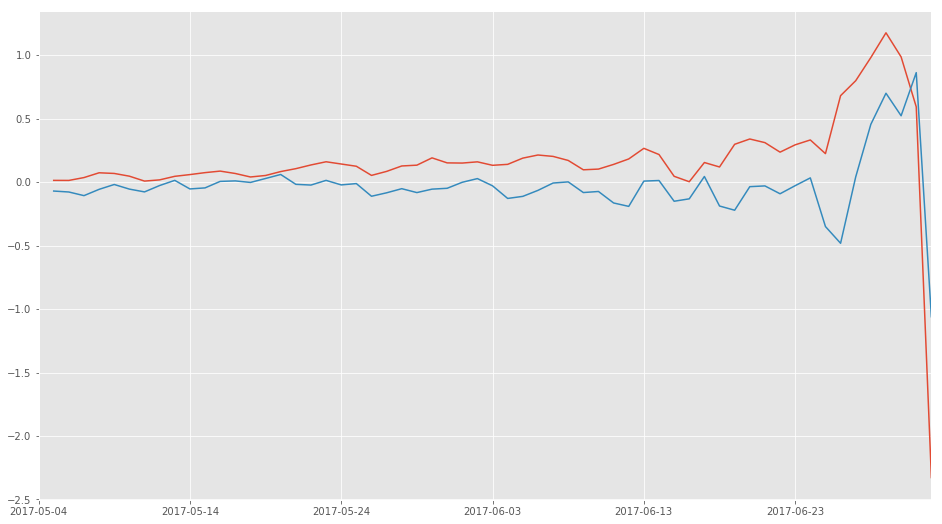

In [14]:
yhat_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()
median_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()

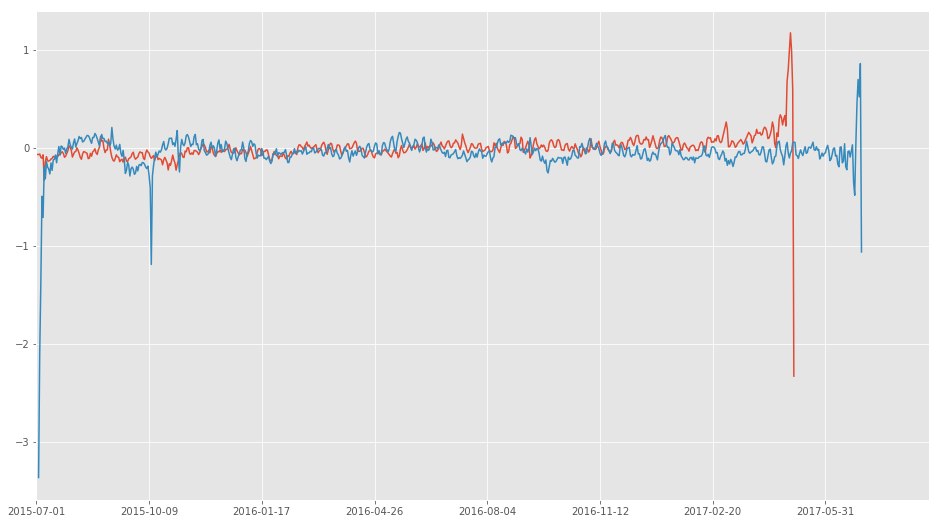

In [15]:
yhat_rolling_smape.diff(1, axis=1).mean(axis=0).plot()
median_rolling_smape.diff(1, axis=1).mean(axis=0).plot()

In [16]:
# remove the yhat smape for the t
yhat_rolling_smape2 = yhat_rolling_smape.copy()
#yhat_rolling_smape2.iloc[:,-120:] = np.nan

In [17]:
cut_off = None
df['rolling_gain_mean'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape.iloc[:,:cut_off]).mean(axis=1)
df['rolling_gain_std'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape.iloc[:,:cut_off]).std(axis=1)

In [18]:
print(df['rolling_gain_mean'].max(), df['rolling_gain_mean'].min())
print(df['rolling_gain_std'].max(), df['rolling_gain_std'].min())

200.0 -193.587283558
172.734306215 0.0


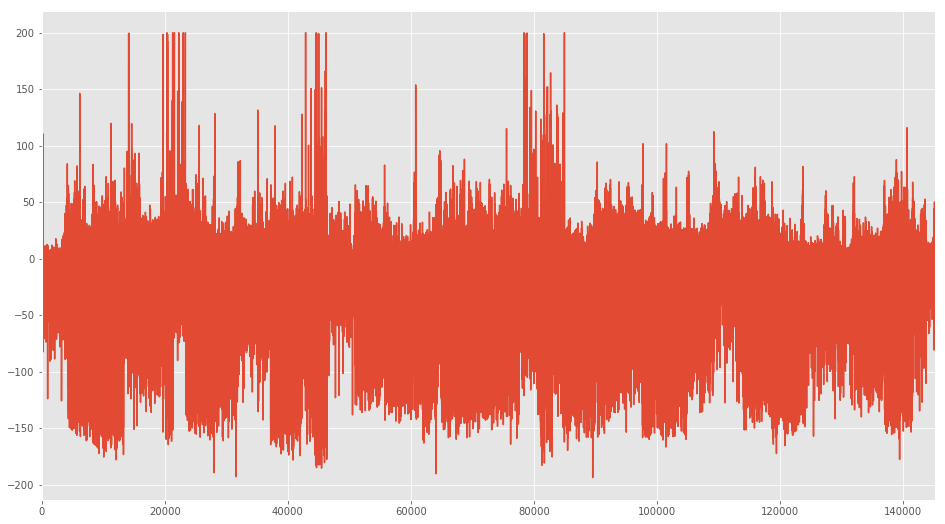

In [19]:
df['rolling_gain_mean'].plot()

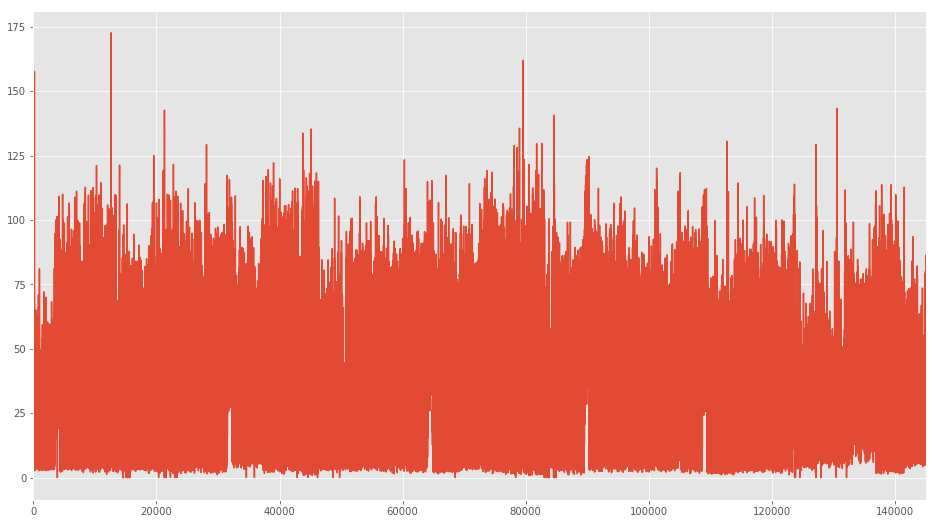

In [20]:
df['rolling_gain_std'].plot()

# Shift preds

In [21]:
y_df = wiki.newphet.load_prophet_prop(VERSION, 'y')

In [22]:
y_df_shift = y_df.shift(365, axis=1).fillna(0)
y_df_shift2 = y_df.shift(364, axis=1).fillna(0)
y_df_shiftBad = y_df.shift(366, axis=1).fillna(0)
#y_df = y_df.shift(365, axis=1).fillna(0)

In [23]:
train = pd.read_feather('../data/train_old.f')

In [24]:
y_df_shift_smape = wiki.val.get_smape_df(train,y_df_shift)
y_df_shift2_smape = wiki.val.get_smape_df(train,y_df_shift2)
y_df_shiftBad_smape = wiki.val.get_smape_df(train,y_df_shiftBad)

In [25]:
y_df_shift_smape.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,59.649123,54.945055,22.222222,48.648649,46.153846,103.225806,83.870968,0.000000,100.000000,17.391304
1,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,69.767442,109.090909,13.333333,29.629630,77.551020,93.333333,24.561404,27.450980,123.595506,21.428571
2,200.0,0.0,200.0,200.0,0.0,200.0,0.0,200.0,200.0,200.0,...,40.000000,140.740741,138.461538,46.153846,66.666667,146.666667,120.000000,46.153846,100.000000,127.272727
3,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,123.076923,142.857143,24.390244,61.538462,16.666667,25.000000,28.571429,5.128205,176.068376,50.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,168.000000,164.444444,157.142857,152.000000,180.952381,155.555556,141.176471,163.636364,140.000000,169.230769


In [26]:
df['shift_y_smape'] = y_df_shift_smape.iloc[:,-60:].mean(axis=1)
df['shift_y_smape2'] = y_df_shift2_smape.iloc[:,-60:].mean(axis=1)
df['shift_y_smapeBad'] = y_df_shiftBad_smape.iloc[:,-60:].mean(axis=1)

In [27]:
df['shift_y_gain'] = df.smape_60_to_0 - df['shift_y_smape']

# Filter CV

In [28]:
BASE_SCORE = df.smape_60_to_0.mean()

In [29]:
BASE_SCORE

41.043204039840212

s.best_params_ 
#v1{'a': 1.5, 'b': 2.0, 'c': 8.0, 'd': 0} -> 40.54743243933121
#v2{'a': 1.7999999999999998, 'b': 2.5, 'c': 9, 'd': 0} -> 40.5440
{'a': 1.7999999999999998, 'b': 2.5, 'c': 9, 'd': 0}

In [30]:
#{'a': 1.5, 'b': 2.0, 'c': 6, 'd': 0}
#v1{'a': 1.5, 'b': 2.0, 'c': 8.0, 'd': 0}
filter_df = ((df['rolling_gain_std']*1.5 < df['rolling_gain_mean']*2) &
            (df['Ytest_gain'] > 6) &
             (df['nans_start_to_120'] <= 0)
             )
print(len(df[filter_df]))

6467


In [31]:
pd.concat([df[filter_df].v7t_val,
           df[~filter_df].smape_60_to_0]).mean()

41.003731883034931

In [32]:
pd.concat([df[filter_df].shift_y_smape,
           df[~filter_df].smape_60_to_0]).mean()

40.551880242482788

In [33]:
pd.concat([df[filter_df].shift_y_smape2,
           df[~filter_df].smape_60_to_0]).mean()

40.328822232438021

In [34]:
pd.concat([df[filter_df].shift_y_smapeBad,
           df[~filter_df].smape_60_to_0]).mean()

40.833268524131576

In [76]:
#v1{'a': 1.5, 'b': 2.0, 'c': 8.0, 'd': 0}
filter_df2 = ((df['rolling_gain_std']*1 < df['rolling_gain_mean']*1) &
            (df['Ytest_gain'] > 0) &
             (df['nans_start_to_120'] <= 0)
             )
print(len(df[filter_df2]))

7220


In [77]:
pd.concat([df[filter_df2].v7t_val,
           df[~filter_df2].smape_60_to_0]).mean()

40.942300823384357

In [78]:
pd.concat([df[filter_df2].shift_y_smape,
           df[~filter_df2].smape_60_to_0]).mean()

41.256579500626138

In [79]:
pd.concat([df[filter_df2].shift_y_smape2,
           df[~filter_df].smape_60_to_0]).mean()

40.576409841015504

# Saving Results 

In [44]:
# save the pages and val scores
df[filter_df][['page_index','shift_y_smape']].reset_index(drop=True).to_feather(
    '../data/prophet/results/proph_FINAL_test_smape.f')

In [42]:
# save the pages and val scores
# need to grab yhat here I think
y_df_shift[filter_df].iloc[:,-60:].reset_index().rename(columns={'index':'page_index'}).to_feather(
    '../data/prophet/results/proph_FINAL_test_preds.f')